In [33]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp
import requests 
import tiktoken
import torch
import ray
import torch

from transformers import AutoTokenizer, AutoModel
from transformers import pipeline, BertTokenizer
from transformers import pipeline
from openai import OpenAI
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

##### Compile 3-4 articles per stock on a daily interval. From here retrieve its embeddings and 
##### perform zero-shot classification with labels specific towards positive sentiment

##### Run a sentiment analysis on these articles and retrieve this score

##### Calculate momentum factors for these stocks and then determine which ones to buy based of these three factors

### Get news data

In [4]:
def get_news_fmp(tickers):
    api_key = "f913bbd3dad0c411c864c0d960a711e7"
    base_url = "https://financialmodelingprep.com/api/v3/stock_news"
    limit = 1000
    all_data = []
    for ticker in tqdm(tickers):
        page = 0
        while True:
            url = f"{base_url}?tickers={ticker}&page={page}&limit={limit}&apikey={api_key}"
            response = requests.get(url)
            data = response.json()
            if not data or 'error' in data:
                break
            all_data.extend(data)
            page += 1
    
    df = pd.DataFrame(all_data).rename(columns={'symbol':'ticker', 'publishedDate':'date'}).drop('image', axis=1)
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'])
    df['text'] = df['text'].astype(str)
    df = df.set_index(['ticker', 'date']).sort_index(level=['ticker', 'date'])
    return df

In [5]:
tickers = [
    "AAPL",  # Apple - Technology
    "MSFT",  # Microsoft - Technology
    "AMZN",  # Amazon - Consumer Discretionary
    "GOOGL", # Alphabet - Technology
    "FB",    # Meta Platforms - Technology
    "BRK.B", # Berkshire Hathaway - Financials
    "JPM",   # JPMorgan Chase - Financials
    "JNJ",   # Johnson & Johnson - Healthcare
    "V",     # Visa - Financials
    "PG",    # Procter & Gamble - Consumer Goods
    "MA",    # Mastercard - Financials
    "UNH",   # UnitedHealth - Healthcare
    "NVDA",  # NVIDIA - Technology
    "HD",    # Home Depot - Consumer Discretionary
    "DIS",   # Disney - Consumer Discretionary
    "BAC",   # Bank of America - Financials
    "VZ",    # Verizon - Communication Services
    "ADBE",  # Adobe - Technology
    "CMCSA", # Comcast - Communication Services
    "NFLX",  # Netflix - Consumer Discretionary
    "KO",    # Coca-Cola - Consumer Goods
    "NKE",   # Nike - Consumer Discretionary
    "MRK",   # Merck - Healthcare
    "PEP",   # PepsiCo - Consumer Goods
    "T",     # AT&T - Communication Services
    "PFE",   # Pfizer - Healthcare
    "INTC",  # Intel - Technology
    "CSCO",  # Cisco Systems - Technology
    "XOM",   # Exxon Mobil - Energy
    "WMT",   # Walmart - Consumer Discretionary
    "BA",    # Boeing - Industrials
    "MCD",   # McDonald's - Consumer Discretionary
    "ABBV",  # AbbVie - Healthcare
    "CVX",   # Chevron - Energy
    "ORCL",  # Oracle - Technology
    "ACN",   # Accenture - Technology
    "ABT",   # Abbott Laboratories - Healthcare
    "TMO",   # Thermo Fisher Scientific - Healthcare
    "C",     # Citigroup - Financials
    "LLY",   # Eli Lilly - Healthcare
    "MDT",   # Medtronic - Healthcare
    "DHR",   # Danaher - Healthcare
    "GILD",  # Gilead Sciences - Healthcare
    "F",     # Ford - Consumer Discretionary
    "BMY",   # Bristol Myers Squibb - Healthcare
    "IBM",   # IBM - Technology
    "MMM",   # 3M - Industrials
    "GE",    # General Electric - Industrials
    "HON",   # Honeywell - Industrials
    "UPS"    # UPS - Industrials
]

In [6]:
news = get_news_fmp(tickers)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [21:01<00:00, 25.22s/it]


In [7]:
# Remove Duplicate Text
news = news.loc[~news.text.duplicated(keep='first')]

In [8]:
news.to_parquet(get_large_dir(False) / 'data_news.parquet.brotli', compression='brotli')

### Load in news data

In [9]:
start_date = '2010-01-01'
current_date = (date.today()).strftime('%Y-%m-%d')

In [10]:
# Shift all news one date forward to avoid lookahead bias
news = pd.read_parquet(get_large_dir(False) / 'data_news.parquet.brotli')
new_dates = news.index.get_level_values('date') + pd.DateOffset(days=1)
new_index = pd.MultiIndex.from_arrays([news.index.get_level_values('ticker'), new_dates], names=['ticker', 'date'])
news.index = new_index

### Get Article Embeddings

In [17]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [18]:
# Function to preprocess sentences
def preprocess_sentence(sentence):
    # Make all words lowercase
    sentence = sentence.lower()
    return sentence
        
def get_bert_embedding(sentence):
    # Tokenize the sentence and convert it to tensor
    tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    # Pass the tokens through the BERT model
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Get the output representation of [CLS] token
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    # Convert the PyTorch tensor to a NumPy array
    cls_embedding = cls_embedding.numpy()
    return cls_embedding[0]

In [19]:
# Apply sentence preprocessing
news['cleaned_text'] = news['text'].apply(preprocess_sentence)
news['cleaned_title'] = news['title'].apply(preprocess_sentence)

In [21]:
# Apply the get_bert_embedding function to your cleaned sentences
start_time = time.time()
news['bert_emb_text'] = news['cleaned_text'].apply(get_bert_embedding)
news['bert_emb_title'] = news['cleaned_title'].apply(get_bert_embedding)
total_time = time.time() - start_time
print(f"Total Time: {total_time}")

Total Time: 13492.062808513641


In [22]:
news.to_parquet(get_large_dir(False) / 'data_news_bemb.parquet.brotli', compression='brotli')

### Get Label Embeddings

In [23]:
def cosine_similarity_matrix(embeddings, label_embedding):
    # Normalize the label_embedding
    label_norm = np.linalg.norm(label_embedding)
    if label_norm == 0:
        return np.zeros(len(embeddings))

    # Normalize the review embeddings
    embeddings_norm = np.linalg.norm(embeddings, axis=1)
    valid_indices = embeddings_norm != 0

    # Compute cosine similarity
    cosine_sim = np.zeros(len(embeddings))
    cosine_sim[valid_indices] = (embeddings[valid_indices] @ label_embedding) / (embeddings_norm[valid_indices] * label_norm)
    return cosine_sim

def zero_shot(embedding_data, embedding_col, labels, name):
    print("Retrieving label embeddings...")
    data = embedding_data.copy(deep=True)
    label_embeddings = [get_bert_embedding(label) for label in labels]
    embeddings_matrix = np.stack(data[embedding_col].values)

    print("Computing cosine similiarity with label embeddings...")
    for i, label_embedding in enumerate(label_embeddings):
        print("Label: ", i)
        column_name = f'{name}_{i}'
        data[column_name] = cosine_similarity_matrix(embeddings_matrix, label_embedding)
    return data

In [24]:
label_sentence = ["This stock shows promising potential for growth.",
                  "Market trends suggest a strong future for this stock.",
                  "Investor confidence in this stock is high.",
                  "The financial outlook for this stock looks positive.",
                  "Current analyses favor an upward trajectory for this stock."]

In [25]:
cosine_sim_text = zero_shot(news, 'bert_emb_text', label_sentence, 'cos_sim_text')
cosine_sim_title = zero_shot(news, 'bert_emb_title', label_sentence, 'cos_sim_title')

Retrieving label embeddings...
Computing cosine similiarity with label embeddings...
Label:  0
Label:  1
Label:  2
Label:  3
Label:  4
Retrieving label embeddings...
Computing cosine similiarity with label embeddings...
Label:  0
Label:  1
Label:  2
Label:  3
Label:  4


In [26]:
cosine_sim_text['cosine_sim_text_mean'] = cosine_sim_text[[f'cos_sim_text_{i}' for i in range(5)]].mean(axis=1)
cosine_sim_title['cosine_sim_title_mean'] = cosine_sim_title[[f'cos_sim_title_{i}' for i in range(5)]].mean(axis=1)

In [40]:
cosine_sim_comb = pd.merge(cosine_sim_text[['cosine_sim_text_mean', 'cleaned_text', 'cleaned_title']], cosine_sim_title[['cosine_sim_title_mean']],
                           left_index=True, right_index=True, how='inner')

In [42]:
cosine_sim_comb = cosine_sim_comb.loc[~cosine_sim_comb.cleaned_text.duplicated(keep='first')]

In [43]:
AAPL = get_stock_data(cosine_sim_comb, 'AAPL')
AAPL.loc[AAPL.cosine_sim_text_mean < 0.5]

cosine_sim_text_mean  \
ticker date                               
AAPL   2019-04-02              0.409085   
       2019-07-10              0.468617   
       2019-07-31              0.470311   
       2019-08-06              0.425251   
       2019-12-11              0.474085   
       2020-01-11              0.442772   
       2020-02-15              0.368719   
       2020-02-26              0.477922   
       2020-03-25              0.400761   
       2020-04-07              0.371144   
       2020-09-12              0.251194   
       2020-10-21              0.397850   
       2020-10-30              0.397565   
       2020-11-24              0.499740   
       2020-12-22              0.412287   
       2021-04-14              0.464868   
       2021-06-15              0.386780   
       2021-07-28              0.439071   
       2021-09-16              0.099471   
       2021-10-09              0.491951   
       2021-10-30              0.456278   
       2022-08-02              0.439997   
       2022-12-03              0.202074   
       2023-02-14              0.452188   
       2023-06-24              0.445203   
       2023-11-08              0.458182   

                                                        cleaned_text  \
ticker date                                                            
AAPL   2019-04-02  apr.01 -- dallas lawrence, chief brand officer...   
       2019-07-10  executives from amazon.com inc. amzn, +1.84% a...   
       2019-07-31  tom forte, managing director and senior resear...   
       2019-08-06  tom forte, managing director and senior resear...   
       2019-12-11  this holiday season will be the first for the ...   
       2020-01-11  streaming platforms like those of spotify tech...   
       2020-02-15  apple inc  said on friday it would reopen one ...   
       2020-02-26  warren buffett, chairman and ceo of berkshire ...   
       2020-03-25  apple inc. told staff that some of its retail ...   
       2020-04-07  companies like apple, inc. (aapl), general mot...   
       2020-09-12  instagram ceo adam mosseri said the company wi...   
       2020-10-21                                                      
       2020-10-30  oct.29 -- apple inc. reports iphone sales that...   
       2020-11-24  apple's chief security officer on monday was i...   
       2020-12-22  apple inc's (nasdaq: aapl) asian supply chain ...   
       2021-04-14  apr.13 -- apple's first product unveiling of 2...   
       2021-06-15  jun.14 -- apple inc. is working on new apple w...   
       2021-07-28  jul.27 -- gradient investments portfolio manag...   
       2021-09-16  sep.15 -- apple inc. unveiled a new iphone 13 ...   
       2021-10-09  apple stock (nasdaq:aapl) declined by about 9%...   
       2021-10-30  apple inc. aapl, -3.47% did a decent job with ...   
       2022-08-02  apple has been sued in u.s. federal court by f...   
       2022-12-03  coinbase, one of the leading cryptocurrency ex...   
       2023-02-14  california public employees' retirement system...   
       2023-06-24  according to current portfolio statistics, a p...   
       2023-11-08  in a rare move, apple hit pause on development...   

                                                       cleaned_title  \
ticker date                                                            
AAPL   2019-04-02  apple will make a large content acquisition th...   
       2019-07-10  amazon, apple, facebook, google set for capito...   
       2019-07-31  how us-china trade tensions factor into apple ...   
       2019-08-06  apple's efforts to diversfy away from phone bu...   
       2019-12-11            apple card proving costly for retailers   
       2020-01-11  spotify, youtube, other streaming platforms ex...   
       2020-02-15  apple to reopen a store in shanghai on februar...   
       2020-02-26  how coronavirus fears could hit apple's supply...   
       2020-03-25              apple may reopen some stores in april   
     

### Run Sentiment Analysis

In [44]:
# Function to apply sentiment analysis
def analyze_sentiment(text):
    # Tokenize and truncate the text
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
    # Decode to get a truncated string
    truncated_text = tokenizer.decode(inputs[0], skip_special_tokens=True)
    # Perform sentiment analysis
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = BertTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [45]:
start_time = time.time()
cosine_sim_comb['sent_text'], cosine_sim_comb['conf_text'] = zip(*cosine_sim_comb['cleaned_text'].apply(analyze_sentiment))
cosine_sim_comb['sent_title'], cosine_sim_comb['conf_title'] = zip(*cosine_sim_comb['cleaned_title'].apply(analyze_sentiment))
total_time = time.time() - start_time
print(f"Total Time: {total_time}")

Total Time: 6527.654398441315


In [46]:
cosine_sim_comb.to_parquet(get_large_dir(False) / 'data_news_signal.parquet.brotli', compression='brotli')

### News-Based Strategy

In [48]:
cosine_sim_comb['sent_score_text'] = cosine_sim_comb.apply(
    lambda row: 1 if row['sent_text'] == 'POSITIVE' and row['conf_text'] > 0.75 else 
               (-1 if row['sent_text'] == 'NEGATIVE' and row['conf_text'] > 0.75 else 0),
    axis=1)

cosine_sim_comb['sent_score_title'] = cosine_sim_comb.apply(
    lambda row: 1 if row['sent_title'] == 'POSITIVE' and row['conf_title'] > 0.75 else 
               (-1 if row['sent_title'] == 'NEGATIVE' and row['conf_title'] > 0.75 else 0),
    axis=1)

In [49]:
signal = cosine_sim_comb[['cosine_sim_text_mean', 'sent_score_text', 'cosine_sim_title_mean', 'sent_score_title']]

In [50]:
m_signal = signal.groupby(level='ticker').resample('M', level='date').agg({
    'cosine_sim_text_mean': 'mean',
    'cosine_sim_title_mean': 'mean',
    'sent_score_text': 'sum',
    'sent_score_title': 'sum'
})

In [52]:
def generate_buy_signal(row):
    # Define thresholds
    cosine_sim_threshold = 0.8
    sentiment_threshold = 0

    # Calculate average cosine similarity
    avg_cosine_sim = (row['cosine_sim_text_mean'] + row['cosine_sim_title_mean']) / 2

    # Calculate total sentiment score
    total_sentiment = row['sent_score_text'] + row['sent_score_title']

    # Define conditions for strong, mid, and low buy
    if avg_cosine_sim >= cosine_sim_threshold and total_sentiment > sentiment_threshold:
        return 'strong buy'
    elif avg_cosine_sim >= cosine_sim_threshold or total_sentiment > sentiment_threshold:
        return 'mid buy'
    else:
        return 'low buy'

In [53]:
price = get_data_fmp(tickers, start_date, current_date)
price = create_return(price, [1])

Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45ticker/s]


In [54]:
m_signal['buy_signal'] = m_signal.apply(generate_buy_signal, axis=1)

In [55]:
shift_m = m_signal.reset_index()
shift_m['date'] = shift_m['date'] + pd.offsets.MonthBegin(1)
shift_m = shift_m.set_index(['ticker', 'date'])

In [56]:
# Create a date range that covers your daily data period
date_range = pd.date_range(start=price.index.get_level_values('date').min(),
                           end=price.index.get_level_values('date').max(),
                           freq='D')

# Create a complete MultiIndex for reindexing
complete_index = pd.MultiIndex.from_product(
    [shift_m.index.get_level_values('ticker').unique(), date_range],
    names=['ticker', 'date']
)

daily_m_signal = shift_m.reindex(complete_index, method='ffill')
daily_m_signal = daily_m_signal.dropna()

In [57]:
news_port = pd.merge(daily_m_signal, price[['RET_01']], left_index=True, right_index=True, how='inner')

In [77]:
# Calculate historical volatility (standard deviation of returns)
weights = {'strong buy': 1.0, 'mid buy': 0.50, 'low buy': 0.10}
volatility = news_port.groupby(level='ticker')['RET_01'].rolling(window=21).std().droplevel(0)
inverse_volatility = 1 / volatility

# Apply initial signal weights
news_port['signal_weight'] = news_port.apply(lambda row: weights.get(row['buy_signal'], 0), axis=1)

# Combine with inverse volatility weights
news_port['combined_weight'] = news_port['signal_weight'] * inverse_volatility
news_port['abs_weight'] = news_port['combined_weight'].abs()

# Normalize the combined weights
sum_combined_weights_by_day = news_port.groupby('date')['abs_weight'].sum()
news_port['normalized_weight'] = news_port.apply(lambda row: row['combined_weight'] / sum_combined_weights_by_day[row.name[1]] if sum_combined_weights_by_day[row.name[1]] != 0 else 0, axis=1)

# Compute the final weighted daily returns
news_port['final_weighted_return'] = news_port['RET_01'] * news_port['normalized_weight']
portfolio_daily_returns = news_port.groupby('date')['final_weighted_return'].sum()
portfolio_daily_returns = set_timeframe(portfolio_daily_returns, '2016-01-01', '2024-01-01')

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2016-01-05   2016-01-05
End Period                 2023-12-22   2023-12-22
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          135.62%      142.75%
CAGR﹪                     7.71%        7.99%

Sharpe                     0.68         0.76
Prob. Sharpe Ratio         96.97%       98.22%
Smart Sharpe               0.55         0.62
Sortino                    0.94         1.06
Smart Sortino              0.76         0.87
Sortino/√2                 0.66         0.75
Smart Sortino/√2           0.54         0.61
Omega                      1.16         1.16

Max Drawdown               -34.1%       -31.77%
Longest DD Days            718          717
Volatility (ann.)          18.49%       16.55%
R^2                        0.91         0.91
Information Ratio          0.0          0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-08-25,188,-31.773427,-26.733416
2,2022-01-05,2022-09-30,2023-12-22,717,-20.451112,-19.303914
3,2018-10-04,2018-12-24,2019-02-21,141,-15.580755,-12.965811
4,2018-01-29,2018-02-08,2018-08-02,186,-9.813730,-9.334944
5,2020-09-03,2020-10-28,2020-11-12,71,-7.938166,-7.503909


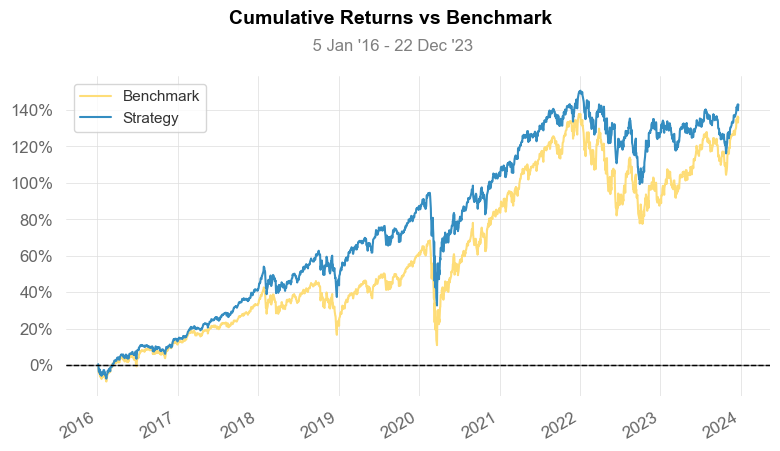

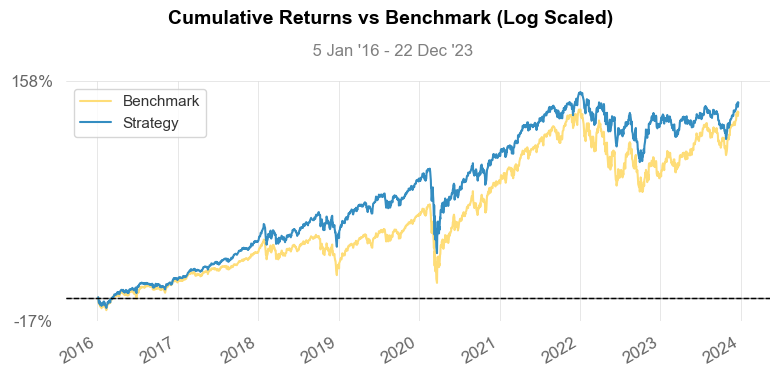

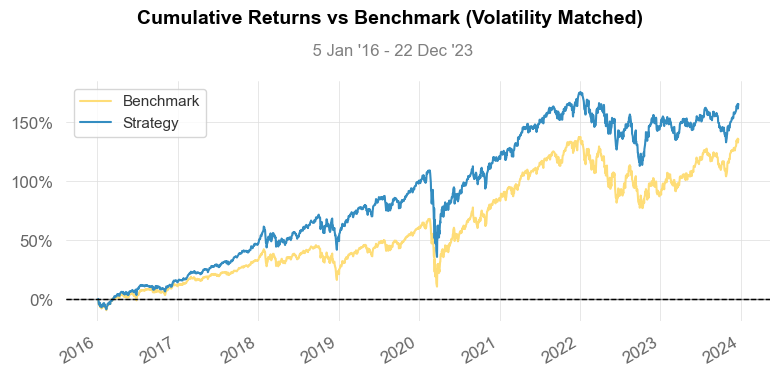

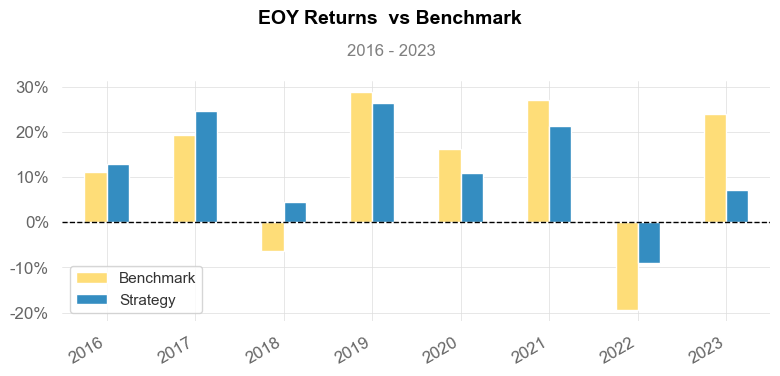

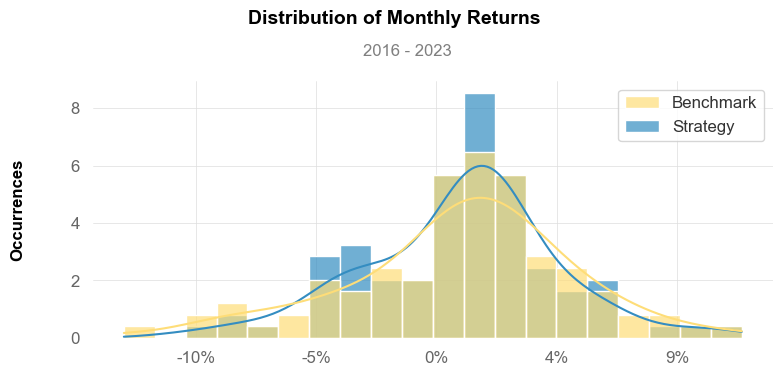

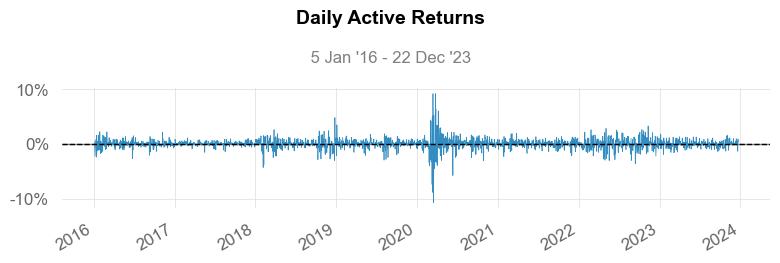

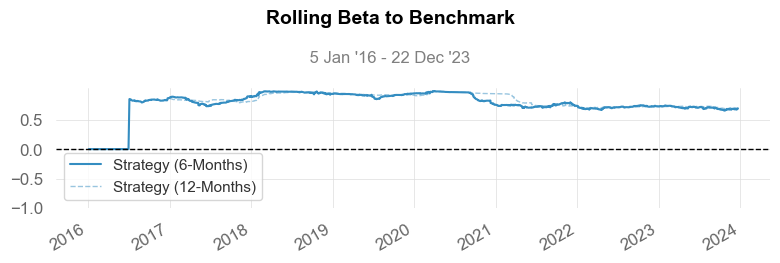

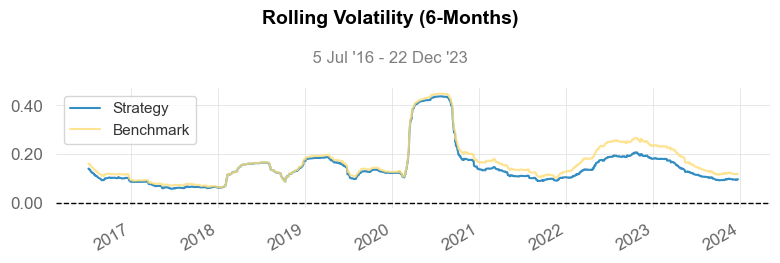

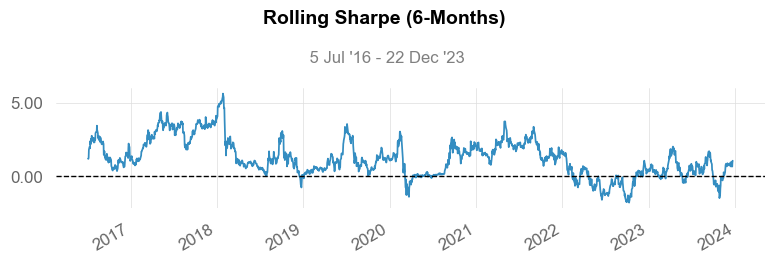

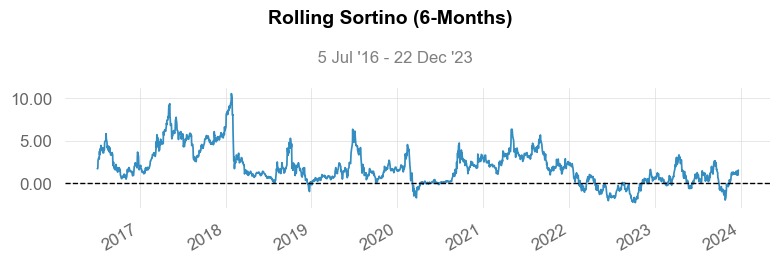

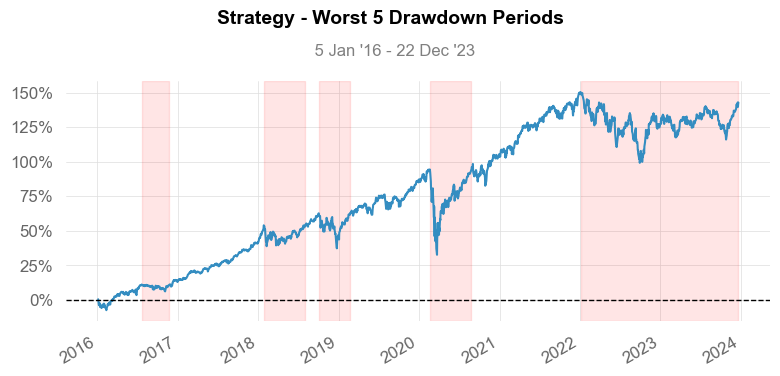

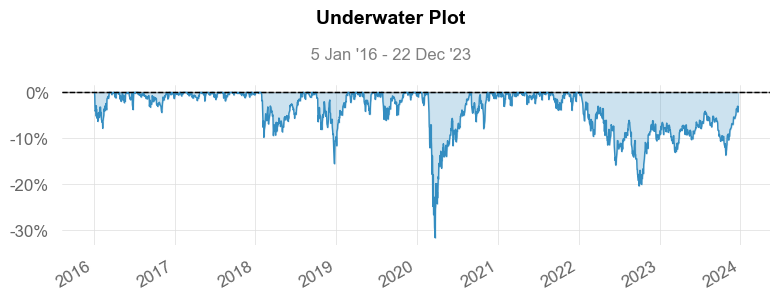

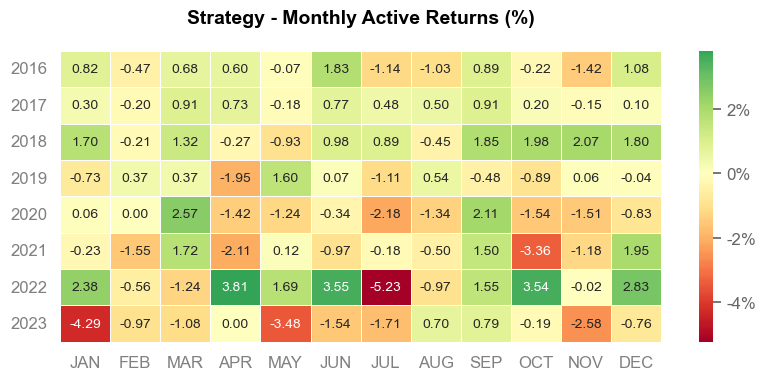

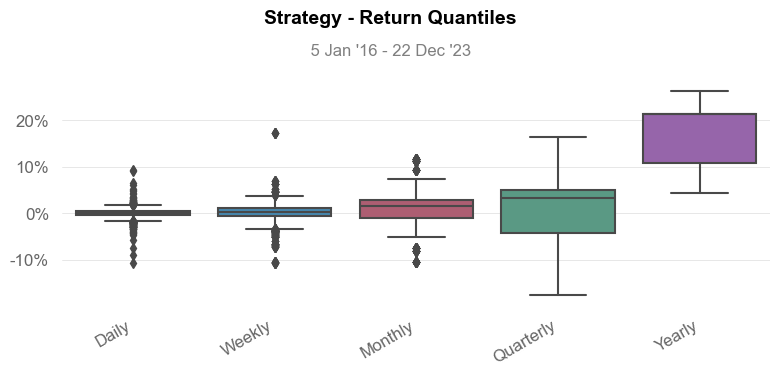

In [78]:
qs.reports.full(portfolio_daily_returns, 'SPY')

### Naive long-hold strategy

In [196]:
naive_long_ret = price.groupby('date')['RET_01'].sum() * (1/len(tickers))

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-05   2010-01-05
End Period                 2023-12-21   2023-12-21
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          317.10%      1,742.43%
CAGR﹪                     7.31%        15.49%

Sharpe                     0.68         1.0
Prob. Sharpe Ratio         99.36%       99.99%
Smart Sharpe               0.63         0.93
Sortino                    0.94         1.45
Smart Sortino              0.87         1.34
Sortino/√2                 0.67         1.02
Smart Sortino/√2           0.62         0.95
Omega                      1.2          1.2

Max Drawdown               -34.1%       -46.79%
Longest DD Days            717          682
Volatility (ann.)          17.4%        23.64%
R^2                        0.64         0.64
Information Ratio          0.05         0.05
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-28,2022-11-03,2023-11-09,682,-46.787366,-44.387206
2,2020-02-20,2020-03-16,2020-05-19,90,-27.467293,-26.779413
3,2018-08-31,2018-12-24,2019-04-18,231,-27.029403,-23.804472
4,2010-04-23,2010-07-02,2010-10-14,175,-16.471268,-16.046480
5,2020-09-03,2020-09-23,2021-01-22,142,-16.461921,-16.076005


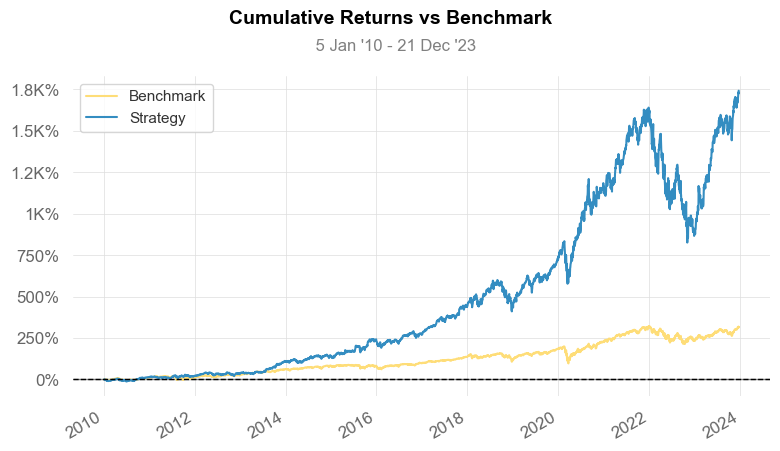

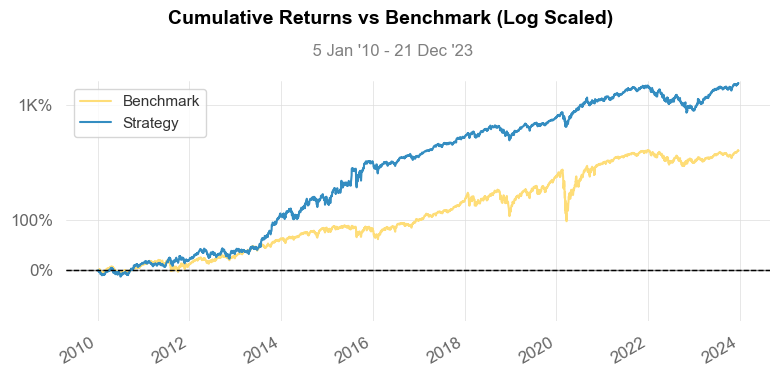

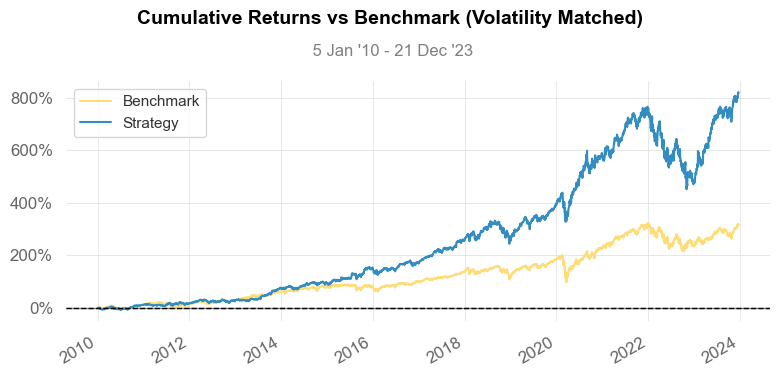

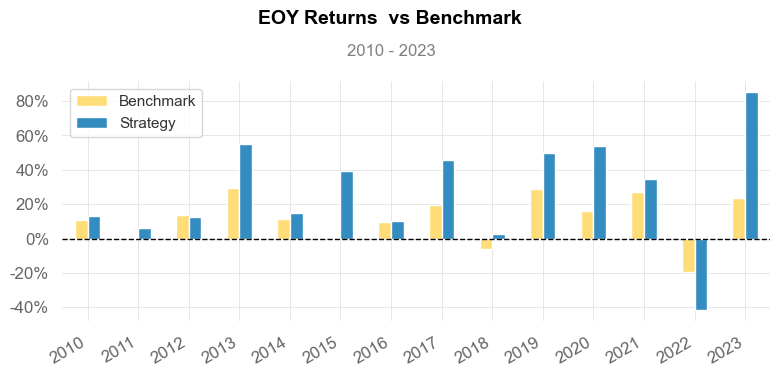

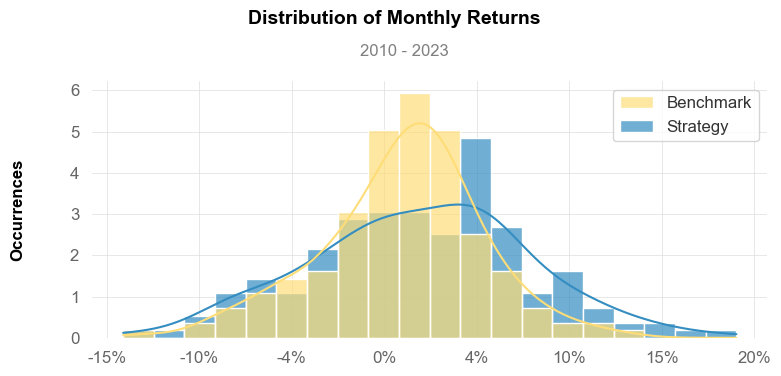

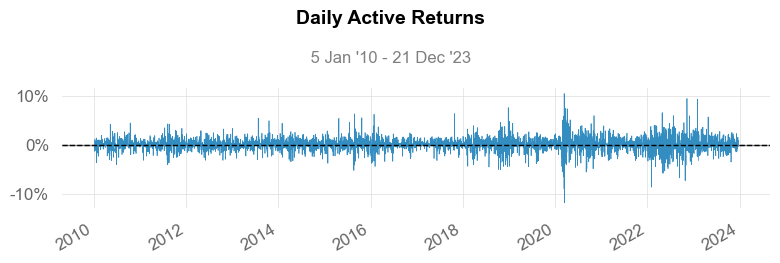

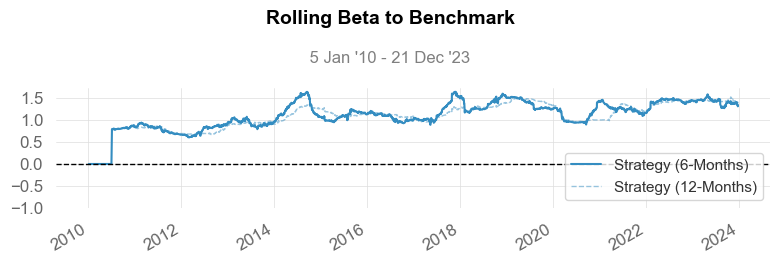

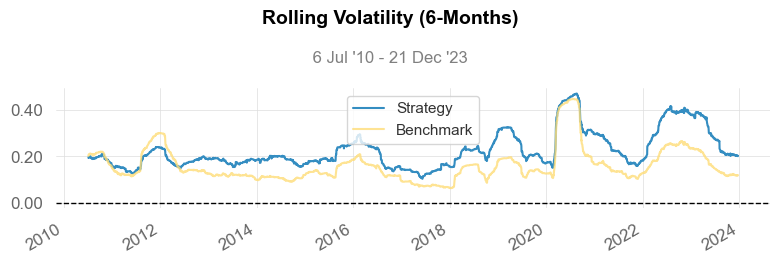

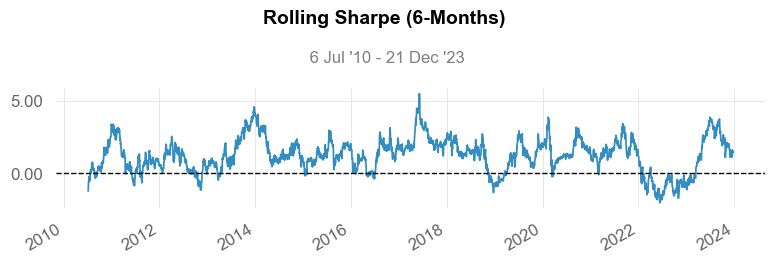

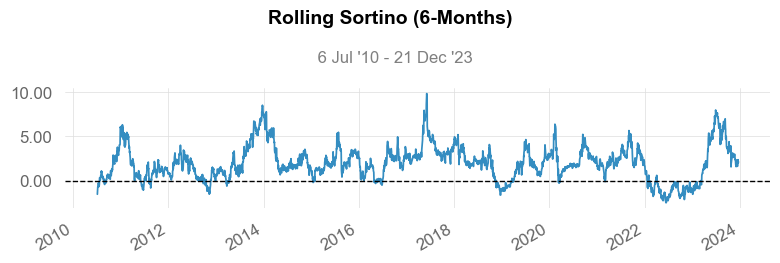

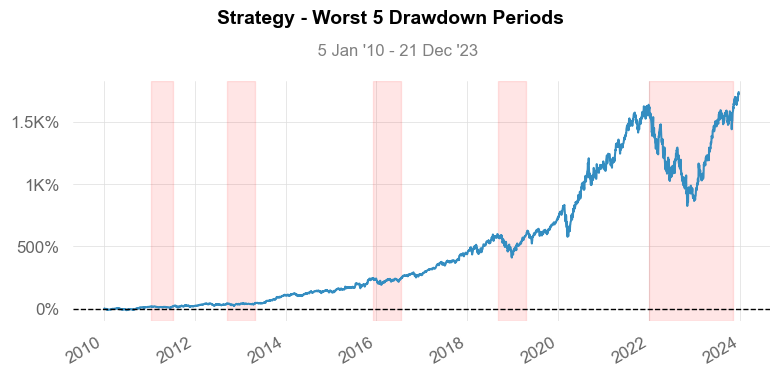

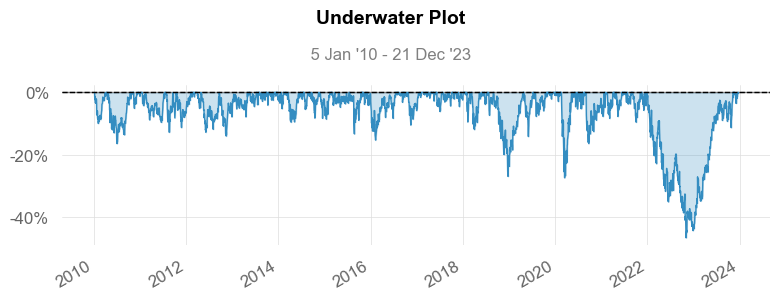

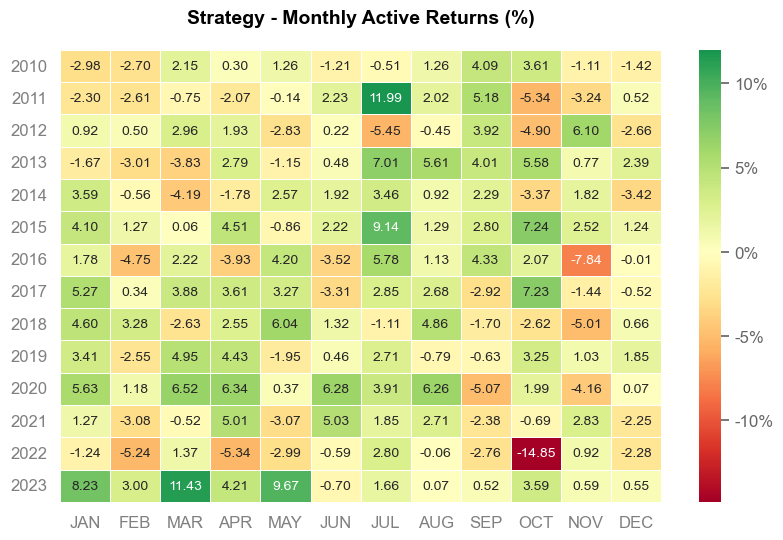

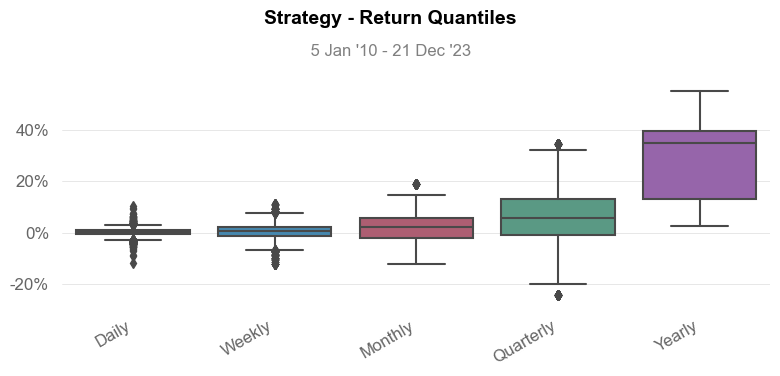

In [31]:
qs.reports.full(naive_long_ret, 'SPY')